Målet er å nøyaktig anslå lengden på sykehusopphold for nye pasienter basert på disse variablene.


## 1 Importer de nødvendige modulene og leser filene

python pakker lovlige
xlrd, numpy, pandas, polars, scipy, sklearn, matplotlib, seaborn, requests, plotly, flask, django, waitress.

In [1]:
import numpy as np 
import pandas as pd
import plotly.express as px
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.dummy import DummyRegressor
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
import matplotlib.pyplot as plt



ModuleNotFoundError: No module named 'plotly'

In [ ]:
demographic_df = pd.read_csv("../raw_data/demographic.csv")
hospital_df = pd.read_csv("../raw_data/hospital.csv")
physiological_df = pd.read_csv("../raw_data/physiological.txt", delimiter='\t')
severity_df = pd.read_json("../raw_data/severity.json")



### 2.0 Data forbredelse

I denne delen skal jeg forstå dataen og inneholdet, rense dataen, Variabelutvinning, normalisere/standarise nummeriske variabler og splitte data i treningssett, valideringssett og testsett

### 2.1 Funksjoner

Lager forhåndsdefinerte funksjoner, så slipper redundans av kode

Histogram for nummeriske variabler som vi vil se sammenhengen til

In [ ]:
def histogram(df, color="teal"):
    for i in df.columns:
        fig = px.histogram(df, x=i, title=i, color_discrete_sequence=[color])
        fig.show()

### 2.2 Merger dataframene

tar ikke med sykdomskategori_id og sykdomskategori

In [ ]:
severity_df = severity_df.explode(["pasient_id", "dødsfall", "sykdom_underkategori", "antall_komorbiditeter", "koma_score", 
                                              "adl_pasient", "adl_stedfortreder", "fysiologisk_score", "apache_fysiologisk_score", "overlevelsesestimat_2mnd",
                                              "overlevelsesestimat_6mnd", "diabetes", "demens","kreft", "lege_overlevelsesestimat_2mnd", "lege_overlevelsesestimat_6mnd",
                                              "dnr_status", "dnr_dag"])

severity_df.set_index('pasient_id', inplace=True)

In [ ]:
merged_df = pd.merge(demographic_df, hospital_df, on="pasient_id") #merger først demographic og sykehus data
merged_2_df = pd.merge(merged_df, physiological_df, on="pasient_id") #merger sammen det medisinske 
df = pd.merge(merged_2_df, severity_df, on="pasient_id") #merger sammen severity data med restens


Vi fyller inn de manglenede Nan verdiene med data fra https://hbiostat.org/data/repo/supportdesc fra Professor Frank Harrell
Dette er baseline verdier som kan brukes til å håndtere manglende data

In [ ]:
df.loc[:, "serumalbumin"] = df["serumalbumin"].fillna(3.5)
df.loc[:, "lungefunksjon"] = df["lungefunksjon"].fillna(333.3)
df.loc[:, "kreatinin"] = df["kreatinin"].fillna(1.01)
df.loc[:, "hvite_blodlegemer"] = df["hvite_blodlegemer"].fillna(9)
df.loc[:, "blodurea_nitrogen"] = df["blodurea_nitrogen"].fillna(6.51)
df.loc[:, "urinmengde"] = df["urinmengde"].fillna(2502)

Fjerner dødsfall, sykehus død, pasient id og sykdomskategori_id og Vi velger å fjerne bilrubin, dette er fordi målingene ikke skjer før dag 7


In [ ]:
df = df.drop(["dødsfall", "sykehusdød", "pasient_id", "bilirubin", "sykdomskategori_id"], axis=1)


### 2.3 Deler inn i trening, test og validerings data 

In [ ]:
df.shape

(7742, 36)

In [ ]:
X = df.drop(columns="oppholdslengde") 
y = df["oppholdslengde"]


X_train, X_rest, y_train, y_rest = train_test_split(X, y, test_size=0.2, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_rest, y_rest, test_size=0.5, random_state=42)




In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6193 entries, 267 to 7270
Data columns (total 35 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   alder                          6193 non-null   float64
 1   kjønn                          6193 non-null   object 
 2   utdanning                      5080 non-null   float64
 3   inntekt                        4179 non-null   object 
 4   etnisitet                      6160 non-null   object 
 5   blodtrykk                      6193 non-null   float64
 6   hvite_blodlegemer              6193 non-null   float64
 7   hjertefrekvens                 6193 non-null   float64
 8   respirasjonsfrekvens           6193 non-null   float64
 9   kroppstemperatur               6193 non-null   float64
 10  lungefunksjon                  6193 non-null   float64
 11  serumalbumin                   6193 non-null   float64
 12  kreatinin                      6193 non-null   floa

### 2.4 Håndtering av manglende verdier og Variabelutvinning





#### Feil verdier 

Vi finner negativ verdi i alder og oppholdslengde, vi fjerner radene fordi det har skjedd feil i data og vi vet ikke om resten av verdiene i raden også inneholder feil

In [ ]:
negative_columns_X = {}
negative_values_y = []

for column in X_train.columns:
    try:
        numeric_col = pd.to_numeric(X_train[column])
        negative_values = X_train[numeric_col < 0]
        if not negative_values.empty:
            negative_columns_X[column] = negative_values[column].tolist()
    except:
        continue

try:
    numeric_y = pd.to_numeric(y_train)
    negative_values_y = y_train[numeric_y < 0].tolist()
except:
    pass

for column, values in negative_columns_X.items():
    print(f"{column}: {values}")

if negative_values_y:
    print(f"y_train: {negative_values_y}")


# Fjerner negative verdier for alle settene
index_train = X_train[X_train["alder"] > 0].index
index_val = X_val[X_val["alder"] > 0].index
index_test = X_test[X_test["alder"] > 0].index

X_train = X_train.loc[index_train]
y_train = y_train.loc[index_train]

X_val = X_val.loc[index_val]
y_val = y_val.loc[index_val]

X_test = X_test.loc[index_test]
y_test = y_test.loc[index_test]

y_train = y_train[y_train > 0]
y_val = y_val[y_val > 0]
y_test = y_test[y_test > 0]


X_train = X_train.loc[y_train.index]
X_val = X_val.loc[y_val.index]
X_test = X_test.loc[y_test.index]

alder: [-1.0, -1.0, -1.0, -1.0]
dnr_dag: [-1.0, -17.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -5.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -8.0, -1.0, -1.0, -27.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -5.0, -1.0, -1.0, -1.0, -1.0, -1.0, -4.0, -13.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -2.0, -4.0, -1.0, -1.0, -1.0, -1.0, -39.0, -1.0, -3.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -4.0, -1.0, -1.0, -3.0, -1.0, -1.0, -15.0, -6.0, -1.0, -1.0, -4.0, -1.0, -1.0, -1.0, -88.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -6.0, -1.0, -1.0, -9.0, -2.0, -1.0, -5.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -12.0, -1.0, -1.0, -1.0, -1.0, -1.0, -3.0, -1.0, -1.0, -9.0, -1.0, -1.0, -1.0, -1.0, -8.0, -11.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -3.0]
y_train: [-99, -99, -99, -99, -99]


#### 2.3.1 Fjerning av variabler og fylle inn for manglende verdier

Deler variablene fra treningsdata med null verdier i en egen dataframe

<Axes: >

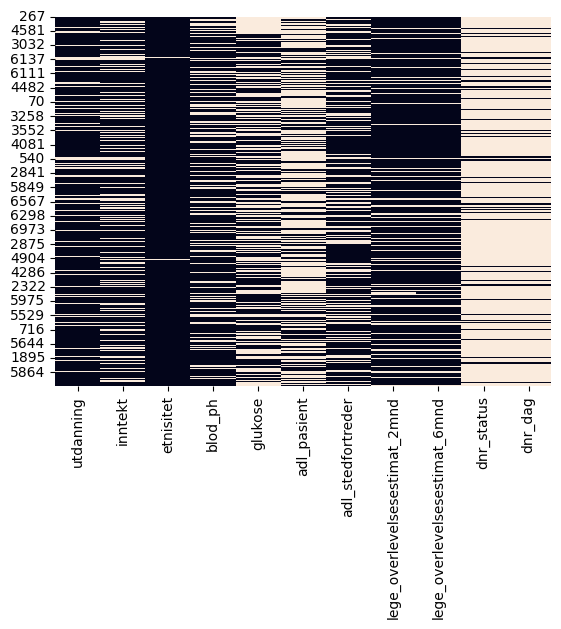

In [ ]:
X_train_null = X_train[X_train.isnull().sum()[X_train.isnull().sum() > 0].index] #deler opp i de som har null verdier
sns.heatmap(X_train_null.isnull(), cbar=False) #plotter de som har null verdier

In [ ]:
null_percentage = X_train_null.isnull().sum() / len(X_train_null) * 100  #prosentvisning av null verdier
print(null_percentage)

utdanning                        17.949547
inntekt                          32.487063
etnisitet                         0.517464
blod_ph                          24.951488
glukose                          49.126779
adl_pasient                      61.934023
adl_stedfortreder                31.694696
lege_overlevelsesestimat_2mnd    18.127426
lege_overlevelsesestimat_6mnd    17.901035
dnr_status                       86.287193
dnr_dag                          86.287193
dtype: float64


I glukose er halvparten av data mangler, vi fjerner derfor denne variablen 

In [ ]:
X_train = X_train.drop(["glukose"], axis=1)
X_val = X_val.drop(["glukose"], axis=1)
X_test = X_test.drop(["glukose"], axis=1)




dnr_status 

dnr_dag har 86% NA verdier, NA verdiene forteller oss at pasienten fikk DNR-orderen en dag etter innleggelsen. Problemet her at vi ikke vet hvilken dag pasienten fikk DNR-orderen eller om pasienten fikk en DNR-order. Det mest hensiktsmessige blir da å fjerene variablen, siden vi mangler stor mengde data. 

In [ ]:

X_train = X_train.drop(["dnr_status", "dnr_dag"], axis=1)
X_val = X_val.drop(["dnr_status", "dnr_dag"], axis=1)
X_test = X_test.drop(["dnr_status", "dnr_dag"], axis=1)


Imputasjon med middelverdi for erstatting av manglende verdier i blod_ph, lege_overlevelsesestimat_2mnd og lege_overlevelsesestimat_6mnd

In [ ]:
print(X_train["blod_ph"].describe())
print(X_train["lege_overlevelsesestimat_2mnd"].describe())
print(X_train["lege_overlevelsesestimat_6mnd"].describe())

imputer = SimpleImputer(strategy='mean')
#bruker verdier fra treningsdata til å ersattte manglende verdier i trenings, validerings og test data
X_train[['blod_ph', "lege_overlevelsesestimat_2mnd", "lege_overlevelsesestimat_6mnd"]] = imputer.fit_transform(X_train[['blod_ph', "lege_overlevelsesestimat_2mnd", "lege_overlevelsesestimat_6mnd"]]) #fyller inn manglende verdier med mean
X_val[['blod_ph', "lege_overlevelsesestimat_2mnd", "lege_overlevelsesestimat_6mnd"]] = imputer.transform(X_val[['blod_ph', "lege_overlevelsesestimat_2mnd", "lege_overlevelsesestimat_6mnd"]])
X_test[['blod_ph', "lege_overlevelsesestimat_2mnd", "lege_overlevelsesestimat_6mnd"]] = imputer.transform(X_test[['blod_ph', "lege_overlevelsesestimat_2mnd", "lege_overlevelsesestimat_6mnd"]])

count    4641.000000
mean        7.415494
std         0.080938
min         6.829102
25%         7.379883
50%         7.429688
75%         7.469727
max         7.769531
Name: blod_ph, dtype: float64
count     5063.0
unique      45.0
top          0.5
freq       704.0
Name: lege_overlevelsesestimat_2mnd, dtype: float64
count     5077.0
unique      75.0
top          0.5
freq       751.0
Name: lege_overlevelsesestimat_6mnd, dtype: float64


For variabelen "utdanning" i datasettet, som representerer antall år med utdanning og mangler 18,1 % av verdiene. Da velges modus-imputasjon som en tilnærming. Dette innebærer å erstatte de manglende verdiene med verdien som forekommer hyppigst i dataene, som i dette tilfellet er 12 år. 

In [ ]:
histogram(X_train[["utdanning"]]) #plotter histogram for utdanning

mode_value = X_train["utdanning"].mode()[0]

X_train["utdanning"] = X_train["utdanning"].fillna(mode_value)


histogram(X_train[["utdanning"]], color="lightcoral")

#fyller inn manglende verdier i validerings og test data
X_val["utdanning"] = X_val["utdanning"].fillna(mode_value)
X_test["utdanning"] = X_test["utdanning"].fillna(mode_value)




#### 2.3.2 Variabelutvinning

adl_pasient og adl_stedfortreder har en del manglende verdier. Først lager vi to varibeler, adl_pasient_none og adl_stedfortreder_none. Deretter sjekker vi om det er noe korrelasjon mellom manglende verdier og verdiene

adl_pasient og adl_stedforteder har høy korrelasjon, vi lager derfor en ny variabel adl hvor vi sammenslår begge kombinerer variablene, hvor adl_stedforteder fyller inn i adl_pasient med verdier som mangler. Deretter for å ikke fjerne den eventuelle endringen fra dag1 til dag7 lager vi en adl endring, som regner ut forskjellen mellom adl på dag1 og dag7

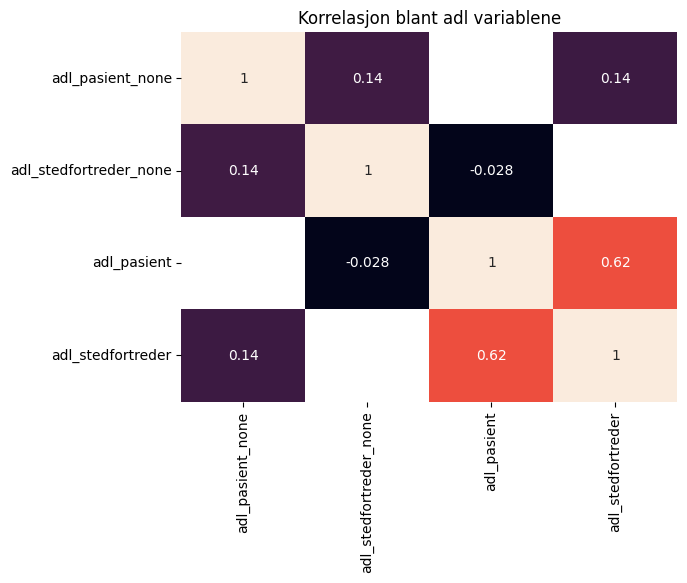

In [ ]:
X_train['adl_pasient_none'] = X_train['adl_pasient'].isnull().astype(int)
X_train['adl_stedfortreder_none'] = X_train['adl_stedfortreder'].isnull().astype(int)

sns.heatmap(X_train[['adl_pasient_none', 'adl_stedfortreder_none', "adl_pasient", "adl_stedfortreder"]].corr(), annot=True, cbar=False)
plt.title("Korrelasjon blant adl variablene")
plt.show()


Nærmest nabo imputasjon

In [ ]:
def process_dataset(df, imputer):
    # Sjekker om ADL-variabler må opprettes, og beregner deretter 'adl' og 'adl_endring'
    if "adl" not in df.columns:
        df["adl"] = round(df["adl_pasient"].combine_first(df["adl_stedfortreder"]), 2)
        df["adl_endring"] = df["adl_stedfortreder"] - df["adl_pasient"]
    
    df[["adl", "adl_endring"]] = imputer.transform(df[["adl", "adl_endring"]])
    
    # Fjerner unødvendige kolonner og runder av resultatene
    df.drop(columns=["adl_stedfortreder", "adl_pasient"], inplace=True)
    df[["adl", "adl_endring"]] = df[["adl", "adl_endring"]].round(2)
    
    # Justerer 'adl_endring' for tilfeller der 'adl' er 0
    df.loc[(df["adl"] == 0) & (df["adl_endring"] != 0), "adl_endring"] = 0
    return df

# Forbereder trenings- og testsett med imputerte verdier
X_train["adl"] = round(X_train["adl_pasient"].combine_first(X_train["adl_stedfortreder"]), 2) #setter sammen adl pasient og adl stedfortreder
X_train["adl_endring"] = X_train["adl_stedfortreder"] - X_train["adl_pasient"]

knn_model = KNNImputer(n_neighbors=2)
knn_model.fit(X_train[["adl", "adl_endring"]])

X_train = process_dataset(X_train, knn_model)
X_val = process_dataset(X_val, knn_model)
X_test = process_dataset(X_test, knn_model)

# Fjerner unødvendige kolonner
X_train.drop(columns=["adl_pasient_none", "adl_stedfortreder_none"], inplace=True)

Etnistet, gjør om manglende verdier til other og samler minoritetsgruppene til other for jevnere fordeling

In [ ]:
histogram(X_train[["etnisitet"]])


X_train["etnisitet"] = X_train["etnisitet"].fillna("other")
X_val["etnisitet"] = X_val["etnisitet"].fillna("other")
X_test["etnisitet"] = X_test["etnisitet"].fillna("other")


X_train["etnisitet"] = X_train["etnisitet"].replace({"black": "other", "hispanic": "other", "asian": "other", "other": "other"})
X_test["etnisitet"] = X_test["etnisitet"].replace({"black": "other", "hispanic": "other", "asian": "other", "other": "other"})
X_val["etnisitet"] = X_val["etnisitet"].replace({"black": "other", "hispanic": "other", "asian": "other", "other": "other"})


histogram(X_train[["etnisitet"]], color="lightcoral")



Inntekt

In [ ]:
histogram(X_train[["inntekt"]])

In [ ]:

#inntekt
X_train['inntekt_mangler'] = X_train['inntekt'].isnull().astype(int)
X_test['inntekt_mangler'] = X_test['inntekt'].isnull().astype(int)
X_val['inntekt_mangler'] = X_val['inntekt'].isnull().astype(int)


X_train = pd.get_dummies(X_train, columns=['inntekt'], prefix='inntekt', drop_first=True, dtype=int)
X_val = pd.get_dummies(X_val, columns=['inntekt'], prefix='inntekt', drop_first=True, dtype=int)
X_test = pd.get_dummies(X_test, columns=['inntekt'], prefix='inntekt', drop_first=True, dtype=int)



Kategoriske variabler til dummies

In [ ]:

X_train = pd.get_dummies(X_train, columns=["kjønn", "sykdom_underkategori", "sykdomskategori", "kreft", "etnisitet"], drop_first=True, dtype=int) 
X_val = pd.get_dummies(X_val, columns=["kjønn", "sykdom_underkategori", "sykdomskategori", "kreft", "etnisitet"], drop_first=True, dtype=int)
X_test = pd.get_dummies(X_test, columns=["kjønn", "sykdom_underkategori", "sykdomskategori", "kreft", "etnisitet"], drop_first=True, dtype=int)


In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6184 entries, 267 to 7270
Data columns (total 44 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   alder                               6184 non-null   float64
 1   utdanning                           6184 non-null   float64
 2   blodtrykk                           6184 non-null   float64
 3   hvite_blodlegemer                   6184 non-null   float64
 4   hjertefrekvens                      6184 non-null   float64
 5   respirasjonsfrekvens                6184 non-null   float64
 6   kroppstemperatur                    6184 non-null   float64
 7   lungefunksjon                       6184 non-null   float64
 8   serumalbumin                        6184 non-null   float64
 9   kreatinin                           6184 non-null   float64
 10  natrium                             6184 non-null   float64
 11  blod_ph                             6184 non-n

In [ ]:
X_train.to_csv('X_train.csv', index=False)


### 2.4 Visualisering

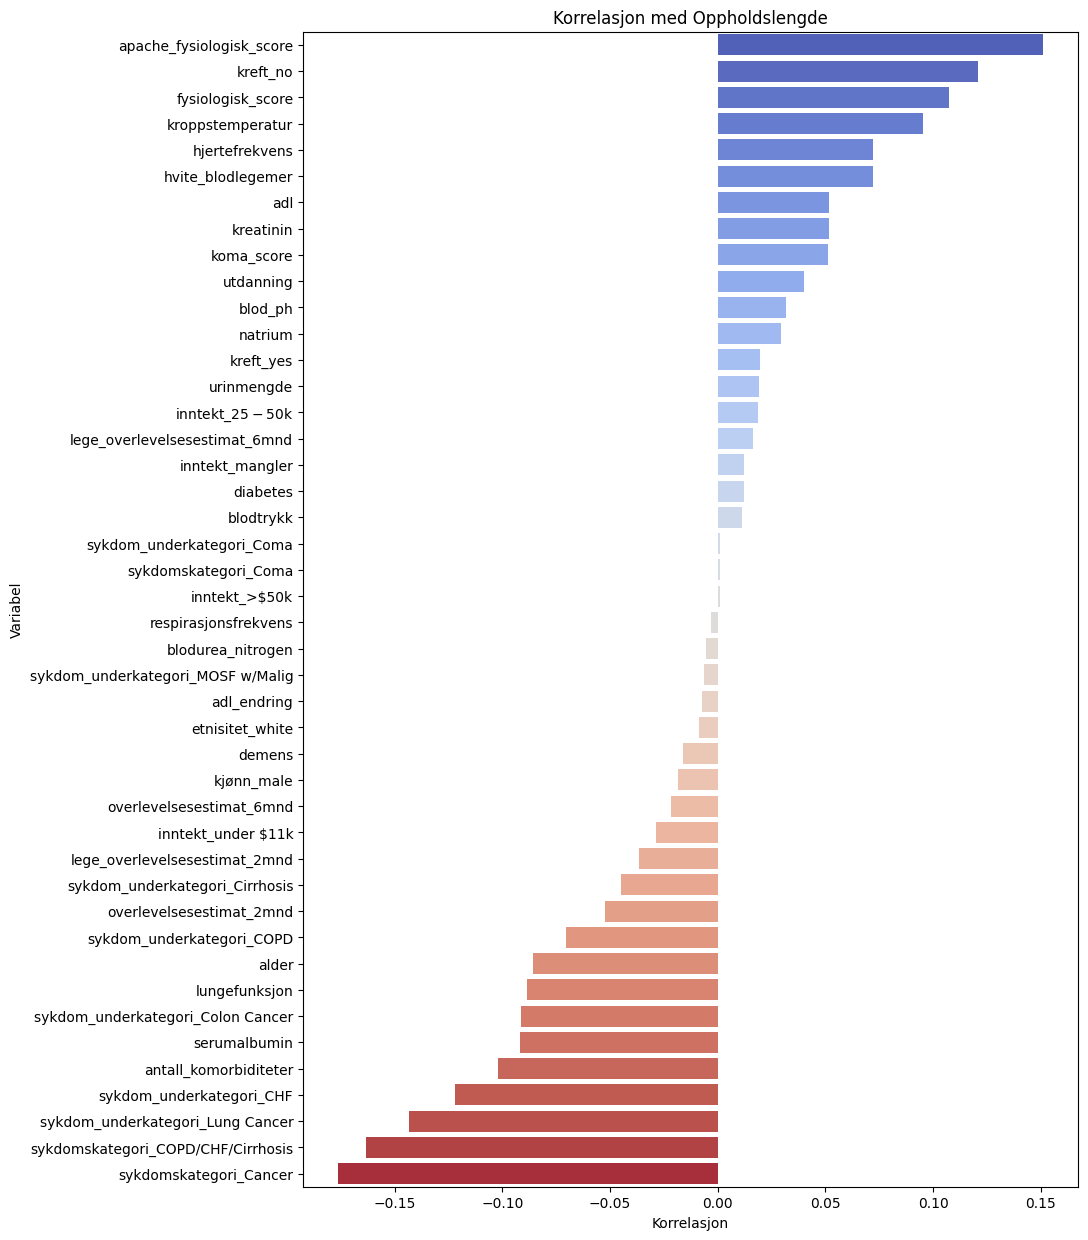

In [ ]:
train_dict = {}

for kolonne in X_train:
    korrelasjon = X_train[kolonne].corr(y_train)
    train_dict[kolonne] = korrelasjon

X_korrelasjon = pd.DataFrame(list(train_dict.items()), columns=['Variabel', 'Korrelasjon']).sort_values(by="Korrelasjon", ascending=False)


plt.figure(figsize=(10, 15))
sns.barplot(y="Variabel", x="Korrelasjon", data=X_korrelasjon, palette="coolwarm", hue="Variabel")
plt.title("Korrelasjon med Oppholdslengde")
plt.xlabel("Korrelasjon")
plt.ylabel("Variabel")
plt.show()

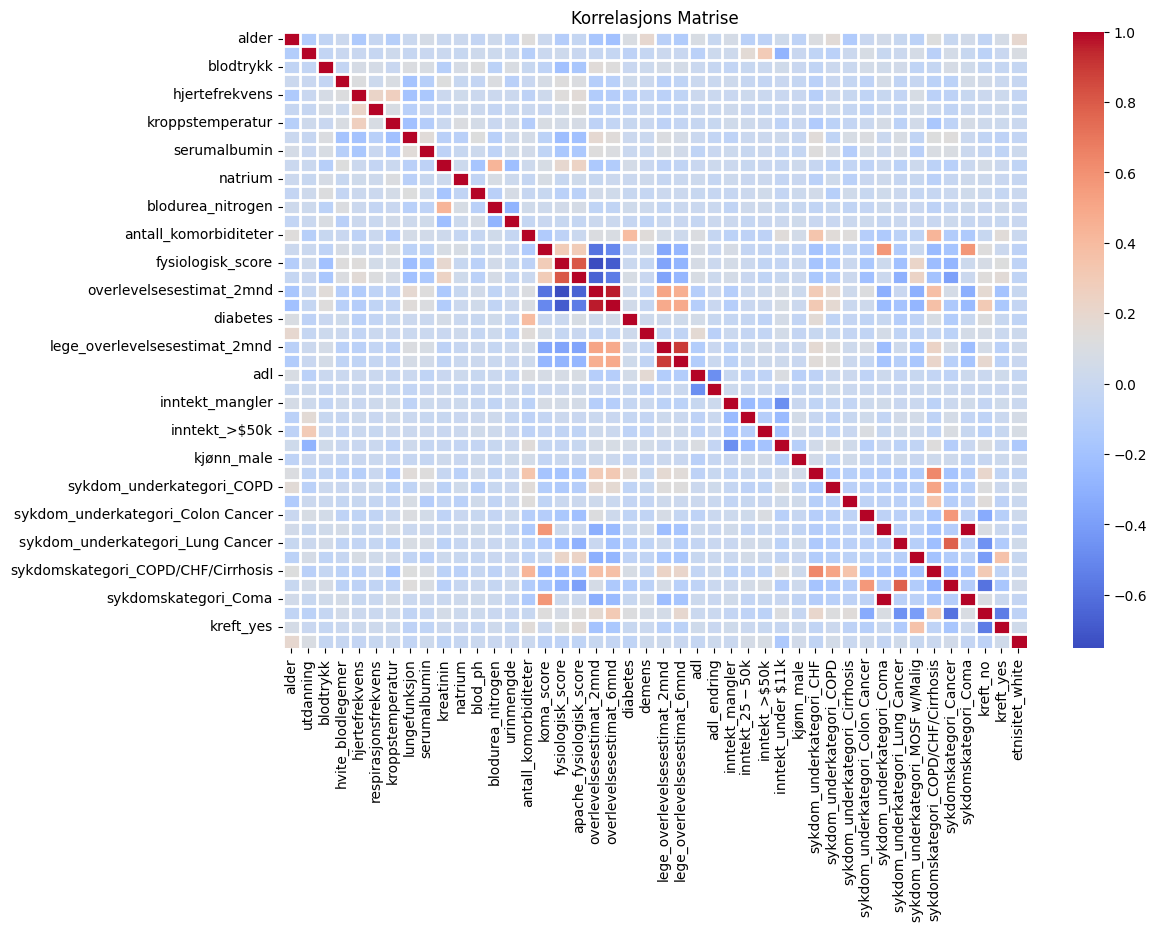

In [ ]:
correlation_matrix = X_train.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, cmap="coolwarm", vmin=-0.75, vmax=1)


for i in range(len(correlation_matrix.columns)):
    plt.axhline(i, color='white', linewidth=2)
    plt.axvline(i, color='white', linewidth=2)

plt.title('Korrelasjons Matrise')
plt.show()




lager scatterplots på variableen som har høy korrelasjon og lav korrelasjon for å se hvordan vi skal håndtere

In [ ]:
#høy korrelasjon
fig = px.scatter(X_train, x="overlevelsesestimat_2mnd", y="overlevelsesestimat_6mnd", color=y_train)
fig.show()

fig = px.scatter(X_train, x="fysiologisk_score", y="apache_fysiologisk_score", color=y_train)
fig.show()

fig = px.scatter(X_train, x="lege_overlevelsesestimat_2mnd", y="lege_overlevelsesestimat_6mnd", color=y_train)
fig.show()

In [ ]:
#lager en ny variabel for aldergrupper, for å visualisere bedre skille mellom alder og oppholdslengde
age_groups = pd.cut(X_train['alder'], bins=[0, 30, 50, 70, 100], labels=['0-30', '30-50', '50-70', '70-100'])

fig = px.scatter(X_train, x="alder", y=y_train, color=age_groups, title="Oppholdslengde vs Alder")
fig.show()

fig = px.scatter(X_train, x="adl", y=y_train, color=y_train, title="Oppholdslengde vs adl")
fig.show()

### 3 Modellering

In [ ]:
baseline = DummyRegressor(strategy="mean")
baseline.fit(X_train, y_train)
y_pred_baseline = baseline.predict(X_val)

mse_baseline = mean_squared_error(y_val, y_pred_baseline)
rmse_baseline = np.sqrt(mse_baseline)

In [ ]:
regr = LinearRegression() 
regr.fit(X_train, y_train) 
y_pred_regr = regr.predict(X_val)

mse_regr = mean_squared_error(y_val, y_pred_regr)
rmse_regr = np.sqrt(mse_regr)

Lasso, å finne rikitg alpha er vanskelig å gjette seg fram, derfor finner vi best alpha med å gå igjennom 50 verdier fra 0 til 50

In [ ]:
lasso_models = {alpha: Lasso(alpha=alpha, max_iter=100000, tol=0.01, warm_start=True) for alpha in np.linspace(0, 5, num=50)}

best_model = None
lowest_rmse = float('inf')

for alpha, model in lasso_models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    
    if rmse < lowest_rmse:
        lowest_rmse = rmse
        lasso_model = model

y_pred_lasso = lasso_model.predict(X_val)
mse_lasso = mean_squared_error(y_val, y_pred_lasso)
rmse_lasso = np.sqrt(mse_lasso)


C:\Users\Pette\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:1473: UserWarning:

With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator

C:\Users\Pette\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:697: UserWarning:

Coordinate descent with no regularization may lead to unexpected results and is discouraged.

C:\Users\Pette\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.193e+06, tolerance: 2.768e+04 Linear regressi

Random Forest-modell

In [ ]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_val)

mse_rf = mean_squared_error(y_val, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)


In [ ]:
print("Første 5 prediksjoner for Baseline:", y_pred_baseline[:5])
print("Første 5 prediksjoner for Linear Regression:", y_pred_regr[:5])
print("Første 5 prediksjoner for Lasso:", y_pred_lasso[:5])
print("Første 5 prediksjoner for Random Forest:", y_pred_rf[:5])


Første 5 prediksjoner for Baseline: [17.53347348 17.53347348 17.53347348 17.53347348 17.53347348]
Første 5 prediksjoner for Linear Regression: [30.03401905 34.72040664 24.74337565 10.56007093 25.14343223]
Første 5 prediksjoner for Lasso: [30.03401905 34.72040664 24.74337565 10.56007093 25.14343223]
Første 5 prediksjoner for Random Forest: [29.36 25.65 19.17  8.92 26.61]


In [ ]:
print(f"Baseline MSE:          {round(mse_baseline,3)} , RMSE: {round(rmse_baseline,3)}")
print(f"Linear Regression MSE: {round(mse_regr,3)}, RMSE: {round(rmse_regr,3)}")
print(f"Lasso MSE:             {round(mse_lasso,3)}, RMSE: {round(rmse_lasso,3)}")
print(f"Random Forest MSE:     {round(mse_rf,3)}, RMSE: {round(rmse_rf,3)}")

Baseline MSE:          597.33 , RMSE: 24.44
Linear Regression MSE: 500.594, RMSE: 22.374
Lasso MSE:             500.594, RMSE: 22.374
Random Forest MSE:     498.352, RMSE: 22.324


Visualiserer modellene 

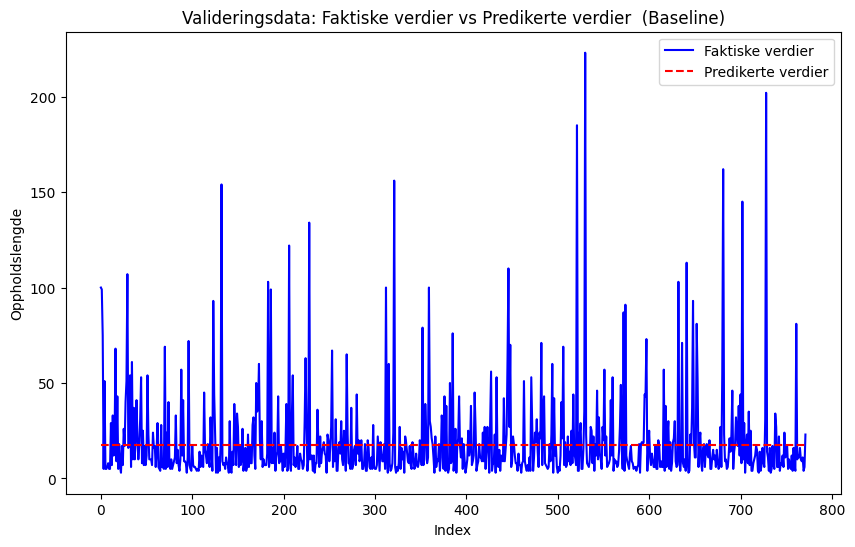

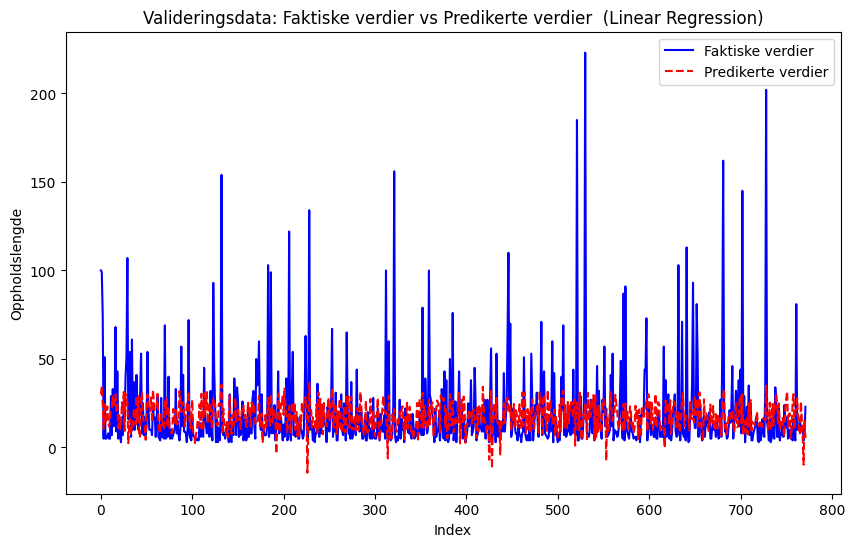

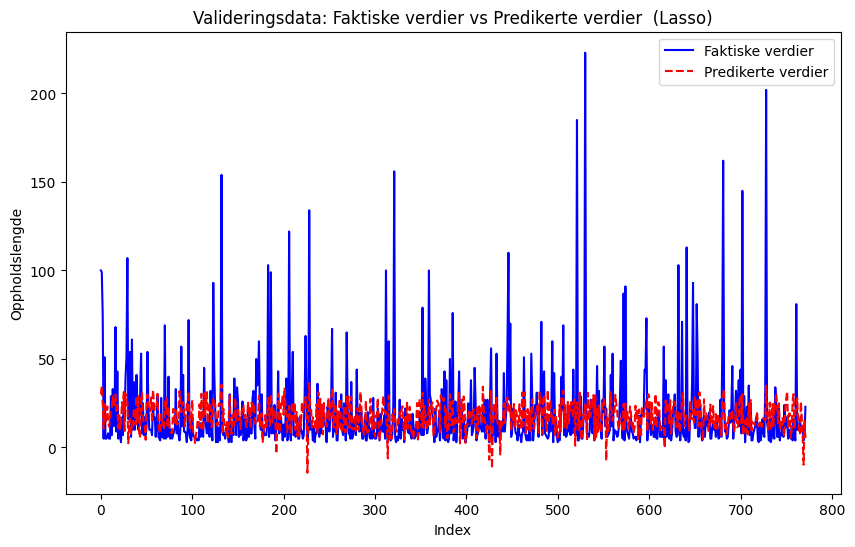

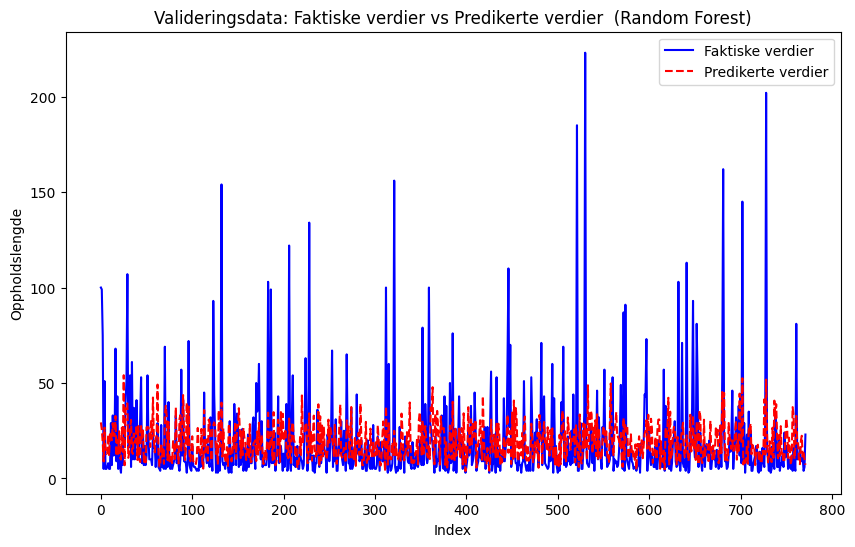

In [ ]:
def plot_actual_vs_predicted(y_val, y_pred, model_name):
    plt.figure(figsize=(10, 6))
    plt.plot(y_val.values, label='Faktiske verdier', color='blue')
    plt.plot(y_pred, label='Predikerte verdier', color='red', linestyle='dashed')
    plt.xlabel('Index')
    plt.ylabel('Oppholdslengde')
    plt.title(f'Valideringsdata: Faktiske verdier vs Predikerte verdier  ({model_name})')
    plt.legend()
    plt.show()



plot_actual_vs_predicted(y_val, y_pred_baseline, "Baseline")
plot_actual_vs_predicted(y_val, y_pred_regr, "Linear Regression")
plot_actual_vs_predicted(y_val, y_pred_lasso, "Lasso")
plot_actual_vs_predicted(y_val, y_pred_rf, "Random Forest")

#### 3.1 Modellutvalg

In [ ]:
model = rf

MSE på testdata 503.9414655483871
RMSE på testdata 22.448640616936856


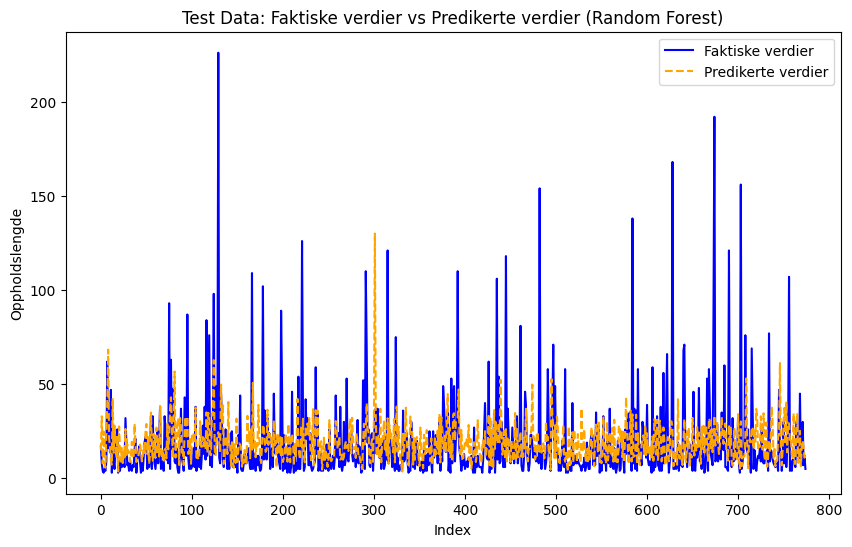

In [ ]:
y_test_pred = model.predict(X_test)
mse_test = mean_squared_error(y_test, y_test_pred)
print("MSE på testdata", mse_test)
print("RMSE på testdata", np.sqrt(mse_test))
 
def plot_actual_vs_predicted_test(y_test, y_test_pred, model_name):
    plt.figure(figsize=(10, 6))
    plt.plot(y_test.values, label='Faktiske verdier', color='blue')
    plt.plot(y_test_pred, label='Predikerte verdier', color='orange', linestyle='dashed')
    plt.xlabel('Index')
    plt.ylabel('Oppholdslengde')
    plt.title(f'Test Data: Faktiske verdier vs Predikerte verdier ({model_name})')
    plt.legend()
    plt.show()
plot_actual_vs_predicted_test(y_test, y_test_pred, "Random Forest")

Lagrer modellen

In [ ]:
import pickle

pickle.dump(model, open('model.pkl', 'wb'))

### 3.2 Prediksjon på sample data

leser og merger data fra sample

In [ ]:
sample_demographic_df = pd.read_csv("../sample_data/demographic.csv")
sample_hospital_df = pd.read_csv("../sample_data/hospital.csv")
sample_physiological_df = pd.read_csv("../sample_data/physiological.txt", delimiter='\t')
sample_severity_df = pd.read_json("../sample_data/severity.json")

sample_severity_df = sample_severity_df.explode(["pasient_id", "dødsfall", "sykdom_underkategori", "antall_komorbiditeter", "koma_score", 
                                              "adl_pasient", "adl_stedfortreder", "fysiologisk_score", "apache_fysiologisk_score", "overlevelsesestimat_2mnd",
                                              "overlevelsesestimat_6mnd", "diabetes", "demens","kreft", "lege_overlevelsesestimat_2mnd", "lege_overlevelsesestimat_6mnd",
                                              "dnr_status", "dnr_dag"])


sample_severity_df.set_index('pasient_id', inplace=True)

sample_merged_df = pd.merge(sample_demographic_df, sample_hospital_df, on="pasient_id") #merger først demographic og sykehus data
sample_merged_2_df = pd.merge(sample_merged_df, sample_physiological_df, on="pasient_id") #merger sammen det medisinske 
sample_df = pd.merge(sample_merged_2_df, sample_severity_df, on="pasient_id") #merger sammen severity data med restens

In [ ]:
from script import fill_missing_values

df_ready = fill_missing_values(sample_df)

nan_values = df_ready.isna().sum()
print(nan_values)

missing_indices = df_ready[df_ready.isna().any(axis=1)].index

df_ready = df_ready.dropna()
sample_df = sample_df.drop(missing_indices)

predicted_stay = model.predict(df_ready)

sample_df['oppholdslengde_predikert'] =np.ceil(predicted_stay).astype(int)  #runder opp til nærmeste heltall

alder                                 0
utdanning                             0
blodtrykk                             1
hvite_blodlegemer                     0
hjertefrekvens                        1
respirasjonsfrekvens                  1
kroppstemperatur                      1
lungefunksjon                         0
serumalbumin                          0
kreatinin                             0
natrium                               1
blod_ph                               0
blodurea_nitrogen                     0
urinmengde                            0
antall_komorbiditeter                 0
koma_score                            1
fysiologisk_score                     1
apache_fysiologisk_score              1
overlevelsesestimat_2mnd              1
overlevelsesestimat_6mnd              1
diabetes                              0
demens                                0
lege_overlevelsesestimat_2mnd         0
lege_overlevelsesestimat_6mnd         0
adl                                   0


In [ ]:
sample_df.to_csv('prediction.csv', index=False)

In [ ]:
sample_df.head(5)

,pasient_id,alder,kjønn,utdanning,inntekt,etnisitet,sykehusdød,blodtrykk,hvite_blodlegemer,hjertefrekvens,...,overlevelsesestimat_2mnd,overlevelsesestimat_6mnd,diabetes,demens,kreft,lege_overlevelsesestimat_2mnd,lege_overlevelsesestimat_6mnd,dnr_status,dnr_dag,oppholdslengde_predikert
0,1,62.84998,male,11.0,$11-$25k,other,0,97.0,6.000000,69.0,...,0.262939,0.036995,0,0,metastatic,0.5,0.25,no dnr,5.0,15
1,22,48.70398,male,16.0,NaN,other,0,66.0,12.500000,125.0,...,0.535889,0.213989,0,0,metastatic,0.5,0.125,dnr ved innleggelse,11.0,13
2,25,29.36099,female,17.0,$25-$50k,white,0,96.0,10.599609,112.0,...,0.853882,0.674927,0,0,metastatic,0.5,0.1,no dnr,4.0,19
3,26,53.84000,male,NaN,under $11k,white,0,134.0,7.799805,106.0,...,0.939941,0.897949,0,0,no,0.9,0.6,dnr ved innleggelse,4.0,10
4,29,30.10799,male,NaN,NaN,asian,0,92.0,8.798828,112.0,...,0.823975,0.764893,0,0,no,None,None,no dnr,10.0,21
